# Stage 5: DeZero advanced challenge

DeZero已经具备了开发神经网络的基本功能，这一阶段将增加一些额外功能，让DeZero更加完善。

In [1]:
import time
import dezero
import dezero.functions as F
import dezero.layers as L
from dezero import optimizers, DataLoader, test_mode, Model
from dezero.models import MLP
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

## Step 52: Support GPU

CuPy拥有与NumPy相似的接口，很容易直接进行迁移。

为了让DeZero支持GPU，要能获取当前数组所属的模块，且要让DeZero能够在NumPy和CuPy之间切换。

In [4]:
import cupy as cp
import numpy as np

# numpy -> cupy
n = np.array([1, 2, 3])
c = cp.array(n)
assert type(c) == cp.ndarray

# cupy -> numpy
c = cp.array([1, 2, 3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

# 获取数组模块
x = np.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == np

x = cp.array([1, 2, 3])
xp = cp.get_array_module(x)
assert xp == cp

In [2]:
# 超参数设置
max_epoch = 5
batch_size = 100

# 数据集
train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)

# 模型
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

# 训练
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 1.9050, time: 14.1970[sec]
epoch: 2, loss: 1.2751, time: 6.1311[sec]
epoch: 3, loss: 0.9201, time: 6.5514[sec]
epoch: 4, loss: 0.7378, time: 5.6780[sec]
epoch: 5, loss: 0.6343, time: 5.6873[sec]


## Step 53: Model saving and loading

DeZero的参数为Parameter类的实例，而Parameter的数据则作为ndarray实例保存在变量data中。使用NumPy的函数来进行保存。

In [3]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])
data = {'x1': x1, 'x2': x2}

np.savez('test.npz', **data)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


Layer的层次结构是一个嵌套的结构，为了取出参数，可以将其“展平”，实际是递归地取出参数。

In [3]:
max_epoch = 3
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((100, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')

for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
    
    print('epoch: {}, loss: {:.4f}'.format(
        epoch + 1, sum_loss / len(train_set)))
    
model.save_weights('my_mlp.npz')

epoch: 1, loss: 0.9778
epoch: 2, loss: 0.8133
epoch: 3, loss: 0.7077


## Step 54: Dropout and test mode

Dropout通过随机删除/禁用神经元来解决模型表现了太强而引起的过拟合问题，达到与集成学习相同的效果。

在测试时，模型使用所有的神经元，但需要进行弱化输出！因为训练时只有一定量的神经元存活，乘以弱化比例使得缩放尺度上保持一致。

In [5]:
dropout_rate = 0.6
x = np.ones(10)

# train
mask = np.random.rand(10) > dropout_rate  # mask掉部分神经元
y = x * mask
print(y)

# test
scale = 1 - dropout_rate
y = x * scale  # 保持相同的缩放尺度
print(y)

[0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]


大部分dl框架都使用Inverted Dropout，在训练时进行缩放处理，测试时就无需进行额外处理。这样还能支持动态的dropout_ratio，Direct Dropout如果动态改变会导致测试时行为不一致。

In [6]:
dropout_rate = 0.6
x = np.ones(10)

# train
scale = 1- dropout_rate
mask = np.random.rand(10) > dropout_rate  # mask掉部分神经元
y = x * mask / scale
print(y)

# test
y = x
print(y)

[0.  0.  0.  2.5 0.  2.5 2.5 2.5 2.5 2.5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


在使用Dropout时需要区分训练阶段和测试阶段，需要进行相应地设置。

In [2]:
x = np.ones(5)
print(x)

y = F.dropout(x)
print(y)

with test_mode():
    y = F.dropout(x)
    print(y)

[1. 1. 1. 1. 1.]
variable([0. 2. 2. 0. 2.])
variable([1. 1. 1. 1. 1.])


## Step 55: CNN Ⅰ

CNN中出现了新的层，卷积层(Convolution layer)和池化层(pooling layer)。

卷积层执行卷积运算，相当于对图像进行过滤操作：
<center>
<img src="./res/conv.png" width="400"/>
</center>

上图卷积核在水平和垂直两个方向上移动，称为二维卷积层Conv2d，当然也有一维卷积层Conv1d和三维卷积层Conv3d。

卷积运算后回缩小图像，为了保持图像大小，可以在卷积运算后进行填充(padding)操作。

In [1]:
def get_conv_output_size(input_size, kernel_size, stride, pad):
    return (input_size + pad * 2 - kernel_size) // stride + 1

H, W = 4, 4  # Input size
KH, KW = 3, 3  # Kernel size
SH, SW = 1, 1  # Stride
PH, PW = 1, 1  # Padding

OH = get_conv_output_size(H, KH, SH, PH)
OW = get_conv_output_size(W, KW, SW, PW)
print(OH, OW)

4 4


## Step 56: CNN Ⅱ

图像除了垂直和水平方向，还在通道方向上排列，DeZero要能处理这种三阶张量。
<center>
<img src="./res/conv2.png" width="400"/>
</center>

池化处理是缩小垂直和水平方向空间的操作，包括最大池化、平均池化等，一般池化窗口大小和步幅设置为相同的值。
1. 没有学习参数
2. 通道数量不发生变化
3. 对微小的位置变化具有鲁棒性


## Step 57: conv2d and pooling

前面介绍了卷积层和池化层的原理，现在着手实现这两个层。

首先实现im2col函数，将图像转换为矩阵，这样就可以使用矩阵乘法来实现卷积运算。避免嵌套使用for循环，提高运算效率。

将要应用卷积核的区域取出，展开最后转换为矩阵，计算直接使用矩阵乘法。
<center>
<img src="./res/img2col.png" width="400"/>
</center>

池化操作则是是对展开后的一列进行操作，取最大值或者平均值。

具体的Function和Layer实现代码量较大，就当作黑盒吧🤦‍♂️

In [2]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)
x2 = np.random.rand(10, 3, 7, 7)
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


## Step 58: Representative CNNs

VGG网络结构如下：
<center>
<img src="./res/vgg.png" width="500"/>
</center>

In [6]:
from dezero.models import VGG16

model = VGG16(pretrained=False)

x = np.random.randn(1,3,224,224).astype(np.float32)
model.plot(x, to_file='./res/VGG16_graph.png')

In [ ]:
url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)

x = VGG16.preprocess(img)
x = x[np.newaxis]

model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = dezero.datasets.ImageNet.labels()
print(labels[predict_id])

## Step 59: Use RNNS to process time series data

之前的网络是前馈网络，输出只取决于输入，而循环神经网络RNN，输出由状态决定，状态由输入进行更新。

h的更新公式如下：
$$
h_t = \tanh(h_{t-1}W_{hh} + x_tW_{xh} + b)
$$

RNN的梯度回传需要进行适当截断，因为RNN的梯度会随着时间步数的增加而指数增长或指数衰减。

In [2]:
class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)
    
    def reset_state(self):
        self.rnn.reset_state()
    
    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y
    
seq_data = [np.random.randn(1, 1) for _ in range(1000)]  # 虚拟的序列数据
xs = seq_data[0:-1]
ts = seq_data[1:]


model = SimpleRNN(10, 1)
loss, cnt = 0, 0

for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    cnt += 1
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

999
(array([0.01702999]), array([0.0485482]))
(array([0.0485482]), array([-0.00790436]))


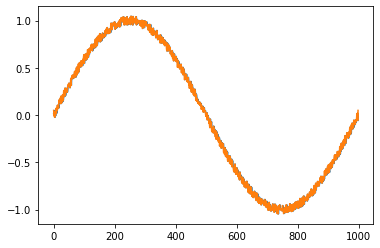

In [3]:
train_set = dezero.datasets.SinCurve(train=True)  # 生成正弦波数据
print(len(train_set))
print(train_set[0])
print(train_set[1])
# 绘制正弦波数据
xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]  # ts就是xs下一步的值
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [ ]:
# 超参数设置
max_epoch = 100
hidden_size = 100
bptt_length = 30  # BPTT的时间长度

# 数据集
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

# 模型、优化器
model = SimpleRNN(hidden_size, 1)
optimizer = optimizers.Adam().setup(model)

# 训练
for epoch in range(max_epoch):
    model.reset_state()  # 重置隐藏状态，每个epoch开始新的序列
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)  # 形状转为(1, 1) batch_size=1
        t = t.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()  # 截断BPTT和清空梯度不一样
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

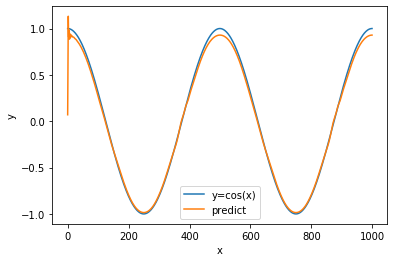

In [6]:
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(pred_list)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()